# K-Nearest Neighbor Implementation

R. Connor Franckowiak

March 22, 2021

In [73]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.stats import mode
import pandas as pd
from scipy.io import arff

## Implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

- Use Euclidean distance to decide closest neighbors. 
- Include optional distance weighting for both algorithms


In [118]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, columntype=[], weight_type='inverse_distance',normalize = False,regression=False): ## add parameters here
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.regression=regression
        self.normalize=normalize
        self.columntype = np.array(columntype) #Note This won't be needed until part 5
        self.weight_type = weight_type
        
    def fit(self, data, labels):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        
        if self.normalize:
            self.mask = self.columntype == "real"
            self.mins = np.min(data[:,self.mask],axis=0)
            self.maxs = np.max(data[:,self.mask],axis=0)
            self.X = data.copy()
            self.X[self.X == b'?'] = np.inf
            self.X[:,self.mask] = (data[:,self.mask].astype(np.float64)-self.mins)/(self.maxs-self.mins)
        else:
            self.X = data
        self.y = labels
        return self
    
    def predict(self, data, k=5):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            k (int): Number of nearest neighbors
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        n_samples = self.X.shape[0]
        #normalize test data according to normalization of training data
        if self.normalize:
            data[:,self.mask] = (data[:,self.mask]-self.mins)/(self.maxs - self.mins)
        predictions = []
        for row in data:
            X_tmp = self.X.copy()
            row_tmp = row.copy()
            #1/0 distance metric for nominal features
            col_mask = self.columntype != "real"
            if True in col_mask:
                #Extend row sample to match size of data, to find whether instance observations match
                broadcast = np.repeat(row[col_mask],repeats=n_samples,axis=0).reshape(np.count_nonzero(col_mask),n_samples).T
                X_tmp[:,col_mask] = np.where(X_tmp == broadcast,0,1)
                row_tmp[col_mask] = 0
            if b'?' in X_tmp or b'?' in row_tmp:
                col_mask = row == b'?'
                row_tmp[col_mask] = int(0)
                X_tmp[col_mask] = int(1)
                missing_mask = X_tmp == b'?'
                np.where(X_tmp == np.inf,row_tmp+1,X_tmp)
            X_tmp[X_tmp == np.inf] = 1
            row_tmp[row_tmp == np.inf] = 0
            #Take euclidean norm and sort args
            X_tmp = X_tmp.astype(np.float64)
            row_tmp = row_tmp.astype(np.float64)
            norms = la.norm(X_tmp - row_tmp,ord=2,axis=1)
            labels = self.y.copy()
            #Find nearest k neighbors and let them vote
            args = np.argsort(norms)[:k]
            nearest=labels[args]
            if self.regression:
                nearest = nearest.astype(np.float64)
                if self.weight_type == "no_weight":
                    predictions.append(np.mean(nearest))
                else:
                    weights = norms[args]
                    votes = nearest/weights**2
                    predictions.append(np.mean(votes))
            else:
                if self.weight_type == "no_weight":
                    predictions.append(mode(nearest)[0][0])
                else:
                    #Inverse weighting
                    weights = norms[args]
                    outputs = np.unique(nearest)
                    votes = []
                    for o in outputs:
                        mask = nearest == o
                        w = weights[mask]**2
                        w_mask = w == 0
                        numerator = np.ones(np.count_nonzero(mask))
                        numerator[w_mask] = np.inf
                        w[w_mask] = 1
                        vote = np.sum(numerator/w)
                        votes.append(vote)
                    predictions.append(outputs[np.argmax(votes)])
                
        predictions = np.array(predictions)
        return predictions

    #Returns the Mean score given input data and labels
    def score(self, X, y,k=5):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        predictions = self.predict(X,k)
        accuracies = predictions == y
        accuracy = np.count_nonzero(accuracies)/predictions.shape[0]
        return accuracy
    

## Debug and Evaluation

Debug and Evaluate model using the parameters below:

- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

---

### Debug

Debug  model by running it on the [seismic bumps](https://archive.ics.uci.edu/ml/datasets/seismic-bumps) problem.
- Using this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_test.arff)
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance


In [119]:
# Load seismic bumps data
# Download file with curl
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output seismic.arff

data = arff.loadarff('seismic.arff')
df = pd.DataFrame(data[0])
df.head()
debug = np.array(df)

X = debug[:,:-1]
y = debug[:,-1]

# Train on training set
knn = KNNClassifier(columntype=["real" for i in range(7)],weight_type="inverse_distance")
knn.fit(X,y)
# Predict on test set
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_test.arff --output seismic_test.arff

data = arff.loadarff('seismic_test.arff')
df = pd.DataFrame(data[0])
df.head()
test = np.array(df)
X = test[:,:-1]
y = test[:,-1]

#Print Accuracy
print("\nAccuracy: ",knn.score(X,y,3))


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  23762      0 --:--:-- --:--:-- --:--:-- 23762
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9597  100  9597    0     0  37635      0 --:--:-- --:--:-- --:--:-- 37635

Accuracy:  0.9357142857142857


### Evaluate

Evaluate model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff)

In [88]:
# Load diabetes data
# Download file with curl
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff --output diabetes_train.arff

data = arff.loadarff('diabetes_train.arff')
df = pd.DataFrame(data[0])
df.head()
debug = np.array(df)

X = debug[:,:-1]
y = debug[:,-1]

# Train on training set
knn = KNNClassifier(columntype=["real" for i in range(8)],weight_type="inverse_distance")
knn.fit(X,y)
# Predict on test set
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff --output diabetes_test.arff

data = arff.loadarff('diabetes_test.arff')
df = pd.DataFrame(data[0])
df.head()
test = np.array(df)
X = test[:,:-1]
y = test[:,-1]

#Print Accuracy
print("\nAccuracy: ",knn.score(X,y,3))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37419  100 37419    0     0   315k      0 --:--:-- --:--:-- --:--:--  315k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73698  100 73698    0     0   525k      0 --:--:-- --:--:-- --:--:--  525k

Accuracy:  0.890625


## Use the k-nearest neighbor algorithm (without distance weighting) for the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) problem

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff) 

- Try it with k=3 and without normalization


In [77]:
# Load magic telescope data
# Download file with curl
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output telescope_train.arff

data = arff.loadarff('telescope_train.arff')
df = pd.DataFrame(data[0])
df.head()
debug = np.array(df)

X = debug[:,:-1]
y = debug[:,-1]

# Train on training set
knn = KNNClassifier(columntype=["real" for i in range(10)],weight_type="no_weight")
knn.fit(X,y)
# Predict on test set
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output telescope_test.arff

data = arff.loadarff('telescope_test.arff')
df = pd.DataFrame(data[0])
df.head()
test = np.array(df)
X = test[:,:-1]
y = test[:,-1]

#Print Accuracy
print("\nAccuracy: ",knn.score(X,y,3))



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  1917k      0 --:--:-- --:--:-- --:--:-- 1921k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0  1341k      0 --:--:-- --:--:-- --:--:-- 1341k

Accuracy:  0.8082808280828083


#### Try it with k=3 and with normalization (input features normalized between 0 and 1). Using the normalization formula (x-xmin)/(xmax-xmin)

In [78]:
# Train/Predict with normalization
# Load magic telescope data
# Download file with curl
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output telescope_train.arff

data = arff.loadarff('telescope_train.arff')
df = pd.DataFrame(data[0])
df.head()
debug = np.array(df)

X = debug[:,:-1]
y = debug[:,-1]

# Train on training set
knn = KNNClassifier(columntype=["real" for i in range(10)],weight_type="no_weight",normalize=True)
knn.fit(X,y)
# Predict on test set
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output telescope_test.arff

data = arff.loadarff('telescope_test.arff')
df = pd.DataFrame(data[0])
df.head()
test = np.array(df)
X = test[:,:-1]
y = test[:,-1]

#Print Accuracy
print("\nAccuracy: ",knn.score(X,y,3))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  3485k      0 --:--:-- --:--:-- --:--:-- 3472k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0  2267k      0 --:--:-- --:--:-- --:--:-- 2267k

Accuracy:  0.8306330633063307


*Discussion of the accuracy results of using normalized data vs. unnormalized data*

Interestingly, the accuracy is increased when we use normalized data.  This is because some of the features have a larger standard deviation than other features, making their euclidean distance increase, and makes the algorithm think that they are "farther away".  However, when we normalize the data, this standardizes the spread of the data, and allows the algorithm to correctly identify the data that is nearest to the point in question.

- Using normalized data, create one graph with classification accuracy on the test set over k values. 
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0  2007k      0 --:--:-- --:--:-- --:--:-- 2007k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0  1330k      0 --:--:-- --:--:-- --:--:-- 1327k


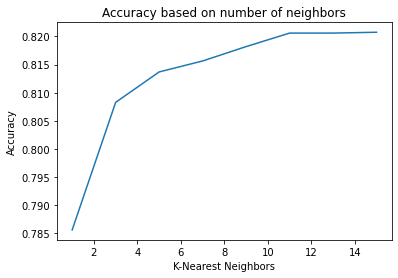

In [98]:
# Train/Predict with normalization
# Load magic telescope data
# Download file with curl
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output telescope_train.arff

data = arff.loadarff('telescope_train.arff')
df = pd.DataFrame(data[0])
df.head()
debug = np.array(df)

X = debug[:,:-1]
y = debug[:,-1]

# Train on training set
knn = KNNClassifier(columntype=["real" for i in range(10)],weight_type="no_weight",normalize=True)
knn.fit(X,y)
# Predict on test set
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output telescope_test.arff

data = arff.loadarff('telescope_test.arff')
df = pd.DataFrame(data[0])
df.head()
test = np.array(df)
X = test[:,:-1]
y = test[:,-1]

# Train/Predict with normalization using k=1,3,...,15
accuracies = []
for k in range(1,16,2):
    accuracies.append(knn.score(X,y,k))
# Graph classification accuracy over k
accuracies = np.array(accuracies)
k = np.arange(1,16,2)
plt.plot(k,accuracies)
plt.xlabel("K-Nearest Neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy based on number of neighbors")
plt.show()

## Using the regression variation of algorithm (without distance weighting) for the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.

- Using this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff).
- Using Mean Square Error (MSE) on the test set as accuracy metric for this case.
- Graph MSE on the test set with odd values of k from 1 to 15


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34205  100 34205    0     0   263k      0 --:--:-- --:--:-- --:--:--  263k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3885  100  3885    0     0  15000      0 --:--:-- --:--:-- --:--:-- 15000


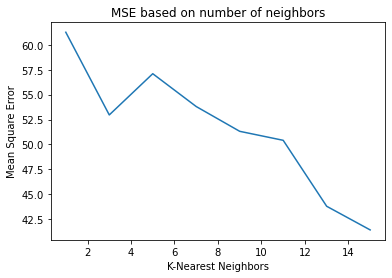

In [107]:
# Load housing price prediction data
# Download file with curl
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output housing_train.arff

data = arff.loadarff('housing_train.arff')
df = pd.DataFrame(data[0])
df.head()
debug = np.array(df)

X = debug[:,:-1]
y = debug[:,-1]

# Train on training set
X[X == b'1'] = int(1)
X[X == b'0'] = int(0)
knn = KNNClassifier(columntype=["real" for i in range(13)],weight_type="no_weight",normalize=True,regression=True)
knn.fit(X,y)
# Predict on test set
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output housing_test.arff

data = arff.loadarff('housing_test.arff')
df = pd.DataFrame(data[0])
df.head()
test = np.array(df)
X = test[:,:-1]
y = test[:,-1]

# Train/Predict using k=1,3,...,15
mses = []
for k in range(1,16,2):
    output = knn.predict(X,k)
    mse = np.mean((output - y)**2)
    mses.append(mse)

# Graph MSE over k
mses = np.array(mses)
ks = np.arange(1,16,2)
plt.plot(ks,mses)
plt.xlabel("K-Nearest Neighbors")
plt.ylabel("Mean Square Error")
plt.title("MSE based on number of neighbors")
plt.show()

## Repeat the experiment for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss the results.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k  100  937k    0     0   780k      0  0:00:01  0:00:01 --:--:--  780k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k  100  505k    0     0  1136k      0 --:--:-- --:--:-- --:--:-- 1133k


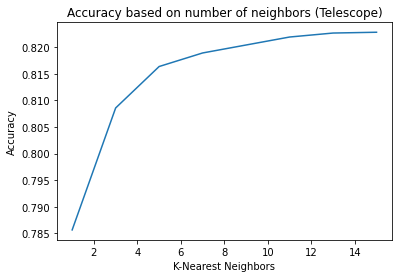

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34205  100 34205    0     0   133k      0 --:--:-- --:--:-- --:--:--  133k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3885  100  3885    0     0  15355      0 --:--:-- --:--:-- --:--:-- 15355


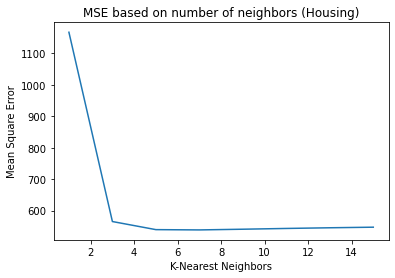

In [103]:
# Train/Predict magic telescope using distance-weighted voting
# Train/Predict with normalization
# Load magic telescope data
# Download file with curl
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output telescope_train.arff

data = arff.loadarff('telescope_train.arff')
df = pd.DataFrame(data[0])
df.head()
debug = np.array(df)

X = debug[:,:-1]
y = debug[:,-1]

# Train on training set
knn = KNNClassifier(columntype=["real" for i in range(10)],weight_type="inverse_distance",normalize=True)
knn.fit(X,y)
# Predict on test set
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output telescope_test.arff

data = arff.loadarff('telescope_test.arff')
df = pd.DataFrame(data[0])
df.head()
test = np.array(df)
X = test[:,:-1]
y = test[:,-1]

# Train/Predict with normalization using k=1,3,...,15
accuracies = []
for k in range(1,16,2):
    accuracies.append(knn.score(X,y,k))
# Graph classification accuracy over k
accuracies = np.array(accuracies)
k = np.arange(1,16,2)
plt.plot(k,accuracies)
plt.xlabel("K-Nearest Neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy based on number of neighbors (Telescope)")
plt.show()

# Train/Predict housing using distance-weighted voting
# Load housing price prediction data
# Download file with curl
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output housing_train.arff

data = arff.loadarff('housing_train.arff')
df = pd.DataFrame(data[0])
df.head()
debug = np.array(df)

X = debug[:,:-1]
y = debug[:,-1]

# Train on training set
X[X == b'1'] = int(1)
X[X == b'0'] = int(0)
knn = KNNClassifier(columntype=["real" for i in range(13)],weight_type="inverse_distance",normalize=True,regression=True)
knn.fit(X,y)
# Predict on test set
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output housing_test.arff

data = arff.loadarff('housing_test.arff')
df = pd.DataFrame(data[0])
df.head()
test = np.array(df)
X = test[:,:-1]
y = test[:,-1]

# Train/Predict using k=1,3,...,15
mses = []
for k in range(1,16,2):
    output = knn.predict(X,k)
    mse = np.mean((output - y)**2)
    mses.append(mse)

# Graph MSE over k
mses = np.array(mses)
ks = np.arange(1,16,2)
plt.plot(ks,mses)
plt.xlabel("K-Nearest Neighbors")
plt.ylabel("Mean Square Error")
plt.title("MSE based on number of neighbors (Housing)")
plt.show()

*Discussion of results*

The Telescope data seems almost identical.  This is likely because the data is fairly concentrated, so its distance doesn't alter the overall determination of the identification.

The Housing, on the other hand, has been altered quite a bit.  Since the regression depends heavily on the values of the nearest predictions, then the MSE dropps off significantly when more neighbors are used, since the very nearest are given much more weight than the others.  This drastically pulls the prediction toward the value of the closest neighbors.

## Use the k-nearest neighbor algorithm to solve the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) (credit-a) problem.

- Uses this [dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff)
    - Uses a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.


In [120]:
#TODO: Debug the use of HEOM Distance Metric 

# Load dataset and split into train/test sets
# Download file with curl
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff --output credit.arff

data = arff.loadarff('credit.arff')
df = pd.DataFrame(data[0])
df.head()
data = np.array(df)

X = data[:,:-1]
y = data[:,-1]

#split
n = X.shape[0]
indices = [i for i in range(n)]
np.random.shuffle(indices)
X = X[indices,:]
y = y[indices]
end = int(n*.7)
X_train = X[:end,:]
y_train = y[:end]
X_test = X[end:,:]
y_test = y[end:]

# Train on training set
coltype = ["categorical","real","real","categorical","categorical","categorical","categorical","real","categorical","categorical","real","categorical","categorical","real","real"]
knn = KNNClassifier(columntype=coltype,weight_type="inverse_distance",normalize=True)
knn.fit(X_train,y_train)

# Train/Predict with normalization using k=1,3,...,15
accuracies = []
for k in range(1,16,2):
    accuracies.append(knn.score(X_test,y_test,k))
# Graph classification accuracy over k
accuracies = np.array(accuracies)
k = np.arange(1,16,2)
plt.plot(k,accuracies)
plt.xlabel("K-Nearest Neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy based on number of neighbors")
plt.show()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34315  100 34315    0     0   319k      0 --:--:-- --:--:-- --:--:--  319k


<ipython-input-118-7a10850eb602>:56: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  X_tmp[:,col_mask] = np.where(X_tmp == broadcast,0,1)


ValueError: array must not contain infs or NaNs

*Explanation of distance metric*

I attempted to use the HEOM and use a distance of 1 with missing values, but I couldn't quite debug the use of a string instead of a number in the real-valued features.

# TODO: Finish exploration of KNN answering the following questions:

## Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare the results.

- Try out different hyperparameters to see how well it can do. 


In [1]:
# Train/Predict magic telescope using scikit's KNN

# Train/Predict housing using scikit's KNN


*Report comparison*

## For the best value of k for any one of the datasets, implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.

- Compare performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. How well does the reduction algorithm work?
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if I use a leave one out style of testing for data set reduction, then your algorithm will run slow since that is n2 at each step.
    - Optionally, use a random subset of 2,000 of the magic telescope instances.
    - More information on reduction techniques can be found [here](http://axon.cs.byu.edu/~martinez/classes/478/slides/IBL.pdf).
